In [1]:
# What are you trying to do?
create_new_model = True
# If create_new_model is True, epochs must have a value
epochs = 10
# If create_new_model is False, load_model_name must have a value
load_model_name = 'model_2021-2-19_1738.pt'

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
# from torchinfo import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod
# math
import math

In [3]:
# =============== LOAD ECG DATA ===============
ecg_00 = np.load('all_none_fs1024_e00.npy')
ecg_03 = np.load('all_none_fs1024_e03.npy')
ecg_06 = np.load('all_none_fs1024_e06.npy')
ecg_clean = np.load('all_none_fs1024_e24.npy')

# Push to CUDA
ecg_00 = torch.from_numpy(ecg_00).cuda().double()
ecg_03 = torch.from_numpy(ecg_03).cuda().double()
ecg_06 = torch.from_numpy(ecg_06).cuda().double()
ecg_clean = torch.from_numpy(ecg_clean).cuda().double()

# Reshape for Torch format
ecg_00 = ecg_00.view( (ecg_00.shape[0], ecg_00.shape[2], ecg_00.shape[1]))
ecg_03 = ecg_03.view( (ecg_03.shape[0], ecg_03.shape[2], ecg_03.shape[1]))
ecg_06 = ecg_06.view( (ecg_06.shape[0], ecg_06.shape[2], ecg_06.shape[1]))
ecg_clean = ecg_clean.view( (ecg_clean.shape[0], ecg_clean.shape[2], ecg_clean.shape[1]))

# Normalize ecg_clean per subset
ecg_00 = et.norm_sig(ecg_00)
ecg_03 = et.norm_sig(ecg_03)
ecg_06 = et.norm_sig(ecg_06)
ecg_clean = et.norm_sig(ecg_clean)

ecg_noisy = ecg_03

# Create ecg_clean_flat version
ecg_clean_flat = ecg_clean.flatten().cpu()
ecg_clean_flat = ecg_clean.numpy()

In [4]:
# Train a new model
if create_new_model:
    # move model to be run by gpu
    model = mod.ae_sampler().cuda()
    model.double()
    # start training the model
    losses = tr.train_model( model=model,
                    epochs=epochs, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_clean,
                    train_pct=0.8)
    save_file_name = 'model_' + str(et.get_local_time()) + '.pt';
    # saved model will have model_YYYY-MM-DD_hhmm.pt format
    torch.save(model.state_dict(), save_file_name)
    print(f'Saved {et.get_local_time()}')
# load model instead if existing
else:
    model = mod.ae_sampler().cuda()
    model.double()
    model.load_state_dict(torch.load(load_model_name))
    model.to('cuda')
    model.eval()

train_size[4435] + valid_size[1109]= 5544
same size
Epoch 1 of 10 || time: 67.01 || loss = 0.18278207177117295
Epoch 2 of 10 || time: 67.26 || loss = 0.10790727904207328
Epoch 3 of 10 || time: 67.98 || loss = 0.10320585685598671
Epoch 4 of 10 || time: 66.98 || loss = 0.10060156841227107
Epoch 5 of 10 || time: 65.36 || loss = 0.09885926106645737
Epoch 6 of 10 || time: 64.20 || loss = 0.09754634287883888
Epoch 7 of 10 || time: 64.09 || loss = 0.09643765949235353
Epoch 8 of 10 || time: 64.06 || loss = 0.09549803900811486
Epoch 9 of 10 || time: 64.22 || loss = 0.09483492759178444
Epoch 10 of 10 || time: 64.48 || loss = 0.09405879968749316
Elapsed time: 655.64, (in mins: 10:55)
Validation dataset has not been used: Available validex set size = 1109
Saved 2021-2-19_2119


In [5]:
ecg_res = et.concat_pt_full(model, ecg_03)

Result size: (4000, 1, 1024)
Result size: (1544, 1, 1024)
Complete shape is: (5544, 1, 1024)
Filename: res_pt_full_2021-2-19_2119


In [11]:
# ecg_res = ecg_res.flatten()
ecg_res = et.realign_starting(ecg_res, ecg_clean_flat.numpy())

Diff: -0.19712596146119143
-0.6257309941520464 - -0.6257309941520464
-0.6257309941520464 - -0.6257309941520464


In [7]:
# ecg_res1 = np.load('res_pt_full_2021-2-19_1813.npy').flatten()
# ecg_res2 = np.load('res_pt_full_2021-2-19_1815.npy').flatten()
# ecg_res3 = np.load('res_pt_full_2021-2-19_1953.npy').flatten()
# ecg_res4 = np.load('res_pt_full_2021-2-19_2044.npy').flatten()

In [8]:
# ecg_res1 = et.realign_starting(ecg_res1, ecg_clean_flat)
# ecg_res2 = et.realign_starting(ecg_res2, ecg_clean_flat)
# ecg_res3 = et.realign_starting(ecg_res3, ecg_clean_flat)
# ecg_res4 = et.realign_starting(ecg_res4, ecg_clean_flat)

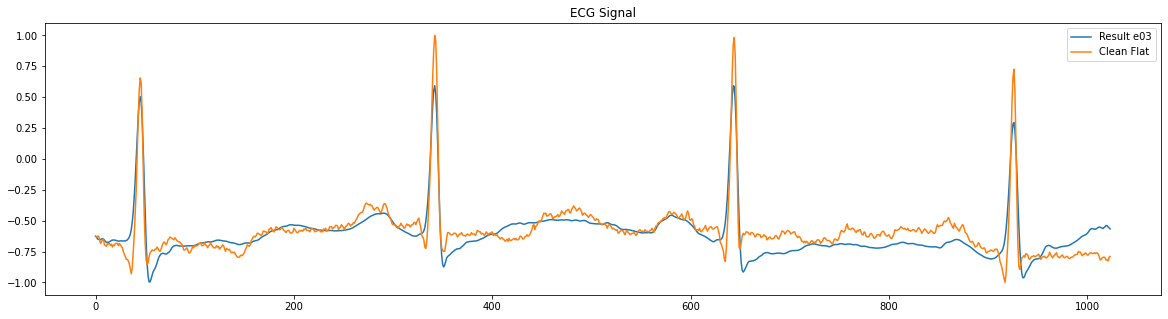

In [12]:
# et.ecg_plot( [ecg_res1, ecg_res2, ecg_res3, ecg_res4, ecg_clean_flat], ['Result e03', 'Clean Flat'])
et.ecg_plot( [ecg_res, ecg_clean_flat], ['Result e03', 'Clean Flat'])